In [1]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset, Dataset, concatenate_datasets
import transformers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix


from transformers import AutoTokenizer, DataCollatorWithPadding,BertForSequenceClassification,TrainingArguments,Trainer

from src.utils.myutils import *
import yaml
from tqdm import tqdm
import logging
import json
import warnings
import random
import pandas as pd

logging.disable(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

CS_DATA_PATH = PATH + '/data/CS/processed/'
CONFIG_PATH = PATH + '/src/utils/config.yaml'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

BATCH_SIZE = 32

In [2]:
babe_train = load_dataset('csv',data_files = CS_DATA_PATH + 'BABE/train.csv')['train']
babe_test = load_dataset('csv',data_files = CS_DATA_PATH + 'BABE/test.csv')['train']
babe_all = load_dataset('csv',data_files = CS_DATA_PATH + 'BABE/babe.csv')['train']

PRETRAINED_PATH = '/home/horyctom/bias-detection-thesis/src/models/trained/all_balanced.pth'
FINAL_PATH = '/home/horyctom/bias-detection-thesis/src/models/trained/final_classifier.pth'
SUBJ_PATH = '/home/horyctom/bias-detection-thesis/src/models/trained/subj_balanced.pth'

## Prepare model

In [89]:
model_all = BertForSequenceClassification.from_pretrained(model_name,num_labels=2)
model_all.load_state_dict(torch.load(PRETRAINED_PATH))

<All keys matched successfully>

## Prepare Data

In [3]:
train_tok = preprocess_data(babe_train,tokenizer,'sentence')
test_tok = preprocess_data(babe_test,tokenizer,'sentence')
babe_tok = preprocess_data(babe_all,tokenizer,'sentence')

# Training

In [91]:
training_args = TrainingArguments(
    output_dir = './',
    num_train_epochs=3,
    per_device_train_batch_size=32,  
    logging_steps=20,
    disable_tqdm = False,
    save_total_limit=2,
    weight_decay=0.1,
    learning_rate=3e-5)

In [92]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.load_state_dict(torch.load(PRETRAINED_PATH))

model.to(device)
trainer = Trainer(model,training_args,train_dataset=train_tok,data_collator=data_collator
                      ,tokenizer=tokenizer)
trainer.train()

eval_dataloader = DataLoader(test_tok, batch_size=BATCH_SIZE, collate_fn=data_collator)
compute_metrics(model,device,eval_dataloader)['f1']

Step,Training Loss
20,0.561600
40,0.499300
60,0.507400
80,0.513800
100,0.438000
120,0.366600
140,0.305300
160,0.275800
180,0.290400
200,0.301900


0.8039869298268728

In [142]:
preds = torch.Tensor([]).to(device)

model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    preds = torch.cat((preds,logits),0)

Confusion matrix, without normalization
[[220  50]
 [ 58 223]]


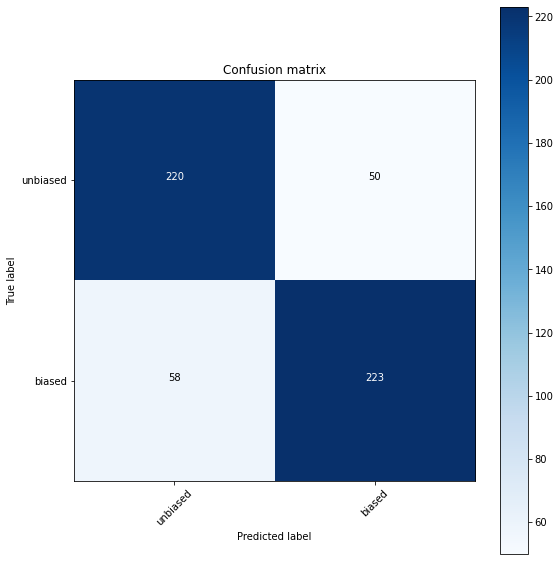

In [143]:
labels = test_tok['label']
preds_prob = F.softmax(preds,dim=1).max(dim=1)[0]
pred_labels = F.softmax(preds,dim=1).argmax(dim=1)

cm = confusion_matrix(labels,pred_labels.cpu())
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,['unbiased','biased'])

In [136]:
misclasified_idx = np.where(pred_labels.cpu()!=labels)[0]

In [145]:
preds_prob[misclasified_idx]

tensor([0.7294, 0.8579, 0.8636, 0.9815, 0.8792, 0.9981, 0.5362, 0.9919, 0.9914,
        0.9971, 0.9970, 0.9141, 0.8567, 0.8192, 0.9400, 0.9949, 0.9885, 0.9965,
        0.7758, 0.7390, 0.6478, 0.7829, 0.9244, 0.9898, 0.5232, 0.5738, 0.9442,
        0.9767, 0.8995, 0.7939, 0.9229, 0.7854, 0.9549, 0.8516, 0.7746, 0.6668,
        0.9855, 0.7847, 0.7638, 0.6456, 0.8795, 0.8618, 0.9361, 0.7658, 0.9538,
        0.8596, 0.9981, 0.7757, 0.9166, 0.9979, 0.9476, 0.9493, 0.6941, 0.9687,
        0.9662, 0.6925, 0.9584, 0.7197, 0.8736, 0.9945, 0.9249, 0.9739, 0.5550,
        0.5514, 0.9913, 0.8031, 0.9921, 0.9663, 0.9577, 0.9907, 0.6277, 0.9721,
        0.9798, 0.9253, 0.9933, 0.7996, 0.5873, 0.8233, 0.9838, 0.9187, 0.7460,
        0.9709, 0.9896, 0.9851, 0.9724, 0.9204, 0.8240, 0.9749, 0.9721, 0.7201,
        0.7762, 0.9334, 0.6061, 0.6302, 0.8023, 0.9777, 0.9511, 0.9681, 0.9780,
        0.8164, 0.8440, 0.9858, 0.9596, 0.9788, 0.9878, 0.5307, 0.9425, 0.9481],
       device='cuda:0')

In [146]:
labels[misclasified_idx]

tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1])

In [147]:
babe_test[misclasified_idx]['sentence'][6]

'Immigration Voice tvrdí, že je nezávislou skupinou, ale údajně úzce spolupracuje s Compete America, skupinou na obranu imigrantů, kterou vytvořily velké technologické společnosti v zemi, z nichž téměř všechny zaměstnávají velké bloky indických a čínských pracovníků s vízy na pracovních místech, která by mohli obsadit mladí američtí absolventi.'

# Final model

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.load_state_dict(torch.load(PRETRAINED_PATH))

model.to(device)
trainer = Trainer(model,training_args,train_dataset=babe_tok,data_collator=data_collator
                      ,tokenizer=tokenizer)
trainer.train()

Step,Training Loss
20,0.564800
40,0.496300
60,0.461800
80,0.492600
100,0.448900
120,0.453500
140,0.308200
160,0.329600
180,0.297000
200,0.294000


0.9678364213527204

In [39]:
torch.save(model.state_dict(),FINAL_PATH)

In [40]:
model1 = BertForSequenceClassification.from_pretrained(model_name,num_labels=2)
model1.load_state_dict(torch.load(PRETRAINED_PATH))

<All keys matched successfully>

In [4]:
model2 = BertForSequenceClassification.from_pretrained(model_name,num_labels=2)
model2.load_state_dict(torch.load(FINAL_PATH))

<All keys matched successfully>

In [74]:
model3 = BertForSequenceClassification.from_pretrained(model_name,num_labels=2)
model3.load_state_dict(torch.load(SUBJ_PATH))

<All keys matched successfully>

In [5]:
model=model2

In [158]:
classify_sentence_certainty('Postavu v Přístavu kvůli mně přejmenovali, vzpomíná Martin Dejdar.')

tensor([[0.7109, 0.2891]], device='cuda:0')

In [7]:
print("Polovina zaměstnanců si nemůže vybrat volno, kdy a jak by chtěla."
"Mužům hrozí za drogy až dvanáct let vězení."
"Exploze v Zákupech: policie čeká na vyjádření expertů."
"Horehroní: po stopách hradních pánů, ale i zbojníků."
"Postavu v Přístavu kvůli mně přejmenovali, vzpomíná Martin Dejdar."
"Český pavilón okouzluje vtipem, návštěvníci nahrávají vzkazy na kameru."
"Znojemský obchvat: druhá stavba začne letos."
"Lyžař Bauer hledá vzpruhu. Chce trénovat s ruskými běžci."
"\"Můžeš vyhrávat pořád dál?\" ptala se Šafářová Plíškové. Chce vládnout společně."
"Komando, které vtrhlo se samopaly do ČT, končí.")

Polovina zaměstnanců si nemůže vybrat volno, kdy a jak by chtěla.Mužům hrozí za drogy až dvanáct let vězení.Exploze v Zákupech: policie čeká na vyjádření expertů.Horehroní: po stopách hradních pánů, ale i zbojníků.Postavu v Přístavu kvůli mně přejmenovali, vzpomíná Martin Dejdar.Český pavilón okouzluje vtipem, návštěvníci nahrávají vzkazy na kameru.Znojemský obchvat: druhá stavba začne letos.Lyžař Bauer hledá vzpruhu. Chce trénovat s ruskými běžci."Můžeš vyhrávat pořád dál?" ptala se Šafářová Plíškové. Chce vládnout společně.Komando, které vtrhlo se samopaly do ČT, končí.


## Experiments

In [14]:
def classify_sentence(sent:str):
    toksentence = tokenizer(sent,truncation=True,return_tensors="pt")
    model.eval()
    model.to(device)
    with torch.no_grad():
        toksentence.to(device)
        output = model(**toksentence)
    
    classification = F.softmax(output.logits,dim=1).argmax(dim=1)
    
    return {0:'unbiased',1:'biased'}[classification[0].item()]

In [15]:
def classify_sentence_certainty(sent:str):
    toksentence = tokenizer(sent,truncation=True,return_tensors="pt")
    model.eval()
    model.to(device)
    with torch.no_grad():
        toksentence.to(device)
        output = model(**toksentence)
    
    classification = F.softmax(output.logits,dim=1)
    
    return classification

In [76]:
print(classify_sentence_certainty('Od března jedeme sedm dní v týdnu a bojujeme s touto ojedinělou situací'))
print(classify_sentence_certainty('ojedinělá situace, na kterou nemohl být nikdo připraven.'))

tensor([[0.7847, 0.2153]], device='cuda:0')
tensor([[0.0374, 0.9626]], device='cuda:0')


In [77]:
print(classify_sentence_certainty('Podle íránské vlády bylo sestřelení IR 655 "Vincennes" úmyslně provedeným a nezákonným činem.'))
print(classify_sentence_certainty('Sestřelení IR 655 "Vincennes" bylo úmyslně provedeným a nezákonným činem.'))

tensor([[0.1404, 0.8596]], device='cuda:0')
tensor([[0.4194, 0.5806]], device='cuda:0')


In [78]:
classify_sentence_certainty('Byli mu prý doporučeni jako "spolehliví a levní" a sám přesvědčil, že je droga od nich kvalitní a čistá.')

tensor([[0.3038, 0.6962]], device='cuda:0')

In [10]:
from newspaper import Article

In [11]:
from nltk import sent_tokenize

In [25]:
print("Řada zaměstnanců se pro získání několika volných dní v celku snaží využít i státní svátky, které kombinuje s krátkou několikadenní dovolenou. Například začátek července, kde se sejdou dva státní svátky za sebou, dává k takovému řešení velkou příležitost. Červencové \"supervolno\" vylidní až polovinu firem, úřadů a institucí v Čechách i na Moravě, potvrzuje exkluzivní reprezentativní průzkum společnosti Wincott People.\nBezmála 50 procent zaměstnanců totiž Den slovanských věrozvěstů Cyrila a Metoděje (5. 7.) a Den upálení mistra Jana Husa (6. 7.) spojuje s oblibou s dalším jedním či více dny řádné dovolené.\nČeši si plánují na tyto červencové svátky především rodinné výlety (30 procent dotázaných), spojí je s řádnou letní dovolenou (16 procent), případně volno využijí pro vylepšení bydlení, pro práci doma, na chatě, chalupě nebo na zahrádce (20 procent).Letní odstávky provozu spojené se závodní dovolenou jsou typické hlavně pro automobilový průmysl.Adrian Suchánek, agentura Wincott People Se třinácti civilními a náboženskými svátky se Česká republika v EU řadí k průměru. Více svátků mají například Německo a Slovensko (16 volných dní), naopak nejméně slaví Nizozemci (9 svátků). Za námi jsou překvapivě i silně katoličtí Poláci s pouhými deseti převážně církevními svátky.\nMinisterstvo financí spočítalo, že jeden státní svátek ekonomiku připraví až o 0,4 procenta ročního hrubého domácího produktu. Červencové \"supervolno\" by tak odhadem mohlo českou ekonomiku při polovičním výkonu firem přijít až na 18,5 miliardy korun. Ekonomové s tím ale tak docela nesouhlasí.\nSice se méně pracuje, ale zpravidla se na druhé straně více spotřebovává – lidé cestují, utrácejí více za služby ubytování nebo pohostinství, nakupují. Řada majitelů chat a rekreačních objektů využije volné dny k přestavbě či vylepšení svých nemovitostí, což je spojeno i s investicemi do stavebního materiálu.\nPři plánování dovolené se musí přes 49 procent zaměstnanců přizpůsobit potřebám svých zaměstnavatelů.\nČást dovolené tak mohou Češi čerpat buď po dohodě, nebo přímo v termínu určeném zaměstnavatelem. Ve větší míře se to týká mužů než žen a spíše obyvatel větších měst. Průzkum Wincott People také dokazuje, že téměř 25 procent pracovníků má problém si v práci vzít souvislé dva týdny dovolené, ačkoli toto právo zakotvuje zákoník práce.Kde nejsou potřeba kvalifikované síly, je možné pracovníky na dovolené nahradit brigádníky, což některé podniky dělají právě v létě.Adrian Suchánek Více než pětině pracovníků určuje zaměstnavatel takzvané celozávodní volno. V 15 procentech případů v pravidelných termínech.\n\"Letní odstávky provozu spojené se závodní dovolenou jsou typické hlavně pro automobilový průmysl. Ty letošní se překryjí s červencovými svátky a připadnou na 4. až 17. července,\" upozornil Adrian Suchánek, personální ředitel agentury Wincott People.\n\"U strojírenských podniků pak záleží, zda má klient zakázky, na kterých se musí pracovat. V tom případě se se zaměstnanci snažíme buď dohodnout na dovolené v jiném termínu, nebo zakázku částečně pokrýváme přesčasy, kdy kupříkladu dva lidé mají dovolenou, další přesčasy a pak se to vymění. Kde nejsou potřeba kvalifikované síly, je možné pracovníky na dovolené nahradit brigádníky, což některé podniky dělají právě v létě,\" dodal Suchánek.")

Řada zaměstnanců se pro získání několika volných dní v celku snaží využít i státní svátky, které kombinuje s krátkou několikadenní dovolenou. Například začátek července, kde se sejdou dva státní svátky za sebou, dává k takovému řešení velkou příležitost. Červencové "supervolno" vylidní až polovinu firem, úřadů a institucí v Čechách i na Moravě, potvrzuje exkluzivní reprezentativní průzkum společnosti Wincott People.
Bezmála 50 procent zaměstnanců totiž Den slovanských věrozvěstů Cyrila a Metoděje (5. 7.) a Den upálení mistra Jana Husa (6. 7.) spojuje s oblibou s dalším jedním či více dny řádné dovolené.
Češi si plánují na tyto červencové svátky především rodinné výlety (30 procent dotázaných), spojí je s řádnou letní dovolenou (16 procent), případně volno využijí pro vylepšení bydlení, pro práci doma, na chatě, chalupě nebo na zahrádce (20 procent).Letní odstávky provozu spojené se závodní dovolenou jsou typické hlavně pro automobilový průmysl.Adrian Suchánek, agentura Wincott People S

In [26]:
with open('text.txt','r') as f:
    text = f.read()


In [96]:
article = Article('https://a2larm.cz/2022/03/clenky-feministickeho-protivalecneho-odporu-putinovo-rusko-je-zakleta-ziva-mrtvola/')
article.download()
article.parse()
sentences = sent_tokenize(article.text)
annotations = np.array(list(zip(sentences,list(map(classify_sentence,sentences)))))
certainity = np.array(list(zip(sentences,list(map(classify_sentence_certainty,sentences)))))

stats = np.unique(annotations[:,1],return_counts=True)
print("bias level: ",stats[1][0]/stats[1].sum()*100,"%")

bias level:  22.463768115942027 %


In [98]:
print(certainity)

[['Feministický protiválečný odpor (Feminističeskoje antivojennoje soprotivlenije, FAS) působí v Rusku a dalších zemích od začátku rusko-ukrajinské války.'
  tensor([[0.9662, 0.0338]], device='cuda:0')]
 ['Cílem tohoto aktivistického hnutí je podle jeho představitelek a představitelů „prolomit informační blokádu“ a šířit informace o válce na Ukrajině.'
  tensor([[0.8613, 0.1387]], device='cuda:0')]
 ['Redakce Meduzy hovořila se dvěma členkami FAS: Darjou Serenkovou, spisovatelkou a aktivistkou z Moskvy, a její kolegyní Táňou (jméno bylo na její žádost změněno), které v prvních dnech války na svém telegramovém kanálu shromáždily více než 24 tisíc lidí.'
  tensor([[0.9589, 0.0411]], device='cuda:0')]
 ['Jak jste se organizovaly?' tensor([[0.9874, 0.0126]], device='cuda:0')]
 ['Inspirovaly jste se jinými podobnými hnutími?'
  tensor([[0.8588, 0.1412]], device='cuda:0')]
 ['Darja: Zorganizovat se bylo snadné.'
  tensor([[0.7742, 0.2258]], device='cuda:0')]
 ['Jsme feministky a queer aktivi

In [97]:
list(filter(lambda x : x[1] == 'biased',annotations))

[array(['Zdá se mi, že právě u těchto lidí by bylo třeba hledat odpověď na otázku po metodologii.',
        'biased'], dtype='<U296'),
 array(['Naše aktivistická optika je – stejně jako každá jiná optika – omezená.',
        'biased'], dtype='<U296'),
 array(['Putin denacifikuje Ukrajinu a zároveň ho v Rusku podporují neonacisté.',
        'biased'], dtype='<U296'),
 array(['Některé ukrajinské feministky tvrdí, že po skončení války dojde k nárůstu domácího násilí, protože muži se vracejí z války s psychickými traumaty, která si vybíjejí na ostatních.',
        'biased'], dtype='<U296'),
 array(['Jedná se o velký problém militarismu, jímž trpí ženy, queer lidi a děti, tedy ty nejzranitelnější skupiny.',
        'biased'], dtype='<U296'),
 array(['Ničí všechny dosavadní úspěchy nevládních organizací, filantropie, feministických a queer komunit.',
        'biased'], dtype='<U296'),
 array(['Válka je extrémní situace a emancipační výdobytky se po jejím skončení často takřka beze stopy vytr

In [74]:
print('Za námi jsou překvapivě i silně katoličtí Poláci s pouhými deseti převážně církevními svátky.',"bias probability:",
      round(classify_sentence_certainty('Za námi jsou překvapivě i silně katoličtí Poláci s pouhými deseti převážně církevními svátky.')[0][1].item()*100,2),"%")
print('Za námi jsou i silně katoličtí Poláci s pouhými deseti převážně církevními svátky.',"bias probability:",
      round(classify_sentence_certainty('Za námi jsou i silně katoličtí Poláci s pouhými deseti převážně církevními svátky.')[0][1].item()*100,2),"%")
print('Za námi jsou i katoličtí Poláci s pouhými deseti převážně církevními svátky.',"bias probability:",
      round(classify_sentence_certainty('Za námi jsou i katoličtí Poláci s pouhými deseti převážně církevními svátky.')[0][1].item()*100,2),"%")
print('Za námi jsou i katoličtí Poláci s deseti převážně církevními svátky.',"bias probability:",
      round(classify_sentence_certainty('Za námi jsou i katoličtí Poláci s deseti převážně církevními svátky.')[0][1].item()*100,2),"%")

Za námi jsou překvapivě i silně katoličtí Poláci s pouhými deseti převážně církevními svátky. bias probability: 98.35 %
Za námi jsou i silně katoličtí Poláci s pouhými deseti převážně církevními svátky. bias probability: 98.0 %
Za námi jsou i katoličtí Poláci s pouhými deseti převážně církevními svátky. bias probability: 91.38 %
Za námi jsou i katoličtí Poláci s deseti převážně církevními svátky. bias probability: 25.37 %


In [95]:
print('Trump nakonec rozhodnul, že zruší slíbené regulace',"bias probability:",
      round(classify_sentence_certainty('Trump nakonec rozhodnul, že zruší slíbené regulace')[0][1].item()*100,2),"%")
print('Trump konečně rozhodnul, že zruší slíbené regulace',"bias probability:",
      round(classify_sentence_certainty('Trump konečně rozhodnul, že zruší slíbené regulace')[0][1].item()*100,2),"%")

Trump nakonec rozhodnul, že zruší slíbené regulace bias probability: 29.47 %
Trump konečně rozhodnul, že zruší slíbené regulace bias probability: 34.65 %


In [66]:
print("Začátky osídlovaní Horehroní se datují někdy okolo roku 2500 před naším letopočtem. Horský drsný terén nepředstavoval takové lákadlo jako níže položené oblasti a tehdejší obyvatelstvo potrápil při chovu dobytka a zemědělské činnosti.\nZlaté časy přišly až později ve 13. století. A to doslova zlaté. Velká část Horehroní byla totiž bohatá na zlato, které se v místních kopcích těžilo ve velkém. Například tehdejší obec Mýto pod Ďumbierom představovala jednu velkou továrnu o rozloze 600 hektarů, v níž se zpracovávala vytěžená hmota, a oddělovalo se zlato od hlušiny. Poprvé na světě byl pro tento proces těžby použit mlýn právě zde, díky čemuž je dodnes možné spatřit hory hlušiny, ale i pozůstatky štol v okolních horách.\nHorehroní se nachází na historicky slavné obchodní cestě Via Magna. Za účelem ochrany této trasy byl postaven hrad Ľupča, který je dnes možné navštívit. Dalšími hrady v regionu jsou Tisovský hrad a hrad Muráň, z nějž však zůstalo již jen torzo. Přesto však představuje oblíbené místo turistů a milovníků koní, zejména pro své unikátní vyhlídky na okolní přírodu Muránské planiny.\nSkrýval se zde Janošík\nTak jako bylo panstvo součástí historie Horehroní, tak jimi byli také zbojníci, kteří někdy bohatým brali a chudým dávali a někdy jen brali a nikomu nic nedali. V sedle Zbojská \"úřadoval\" zbojník Jakub Surovec, kterému je věnován naučný chodník při Salaši Zbojská.\nA o pár kopců dál, nad obcí Klenovec v roce 1713 chytli Janošíka, který se skrýval u Martina Mravce, taktéž zbojníka. Oba byli odsouzeni a krátce na to popraveni. V každém případě i tyto osobnosti vešly do dějin regionu, i když pouze jako opozice tehdejší moci. Zůstaly po nich však, pro turisty oblíbené, Zbojnické chodníčky nedaleko Salaše Zbojská.\nVelkým lákadlem také železnice\nDo dnešních dob na nás dýchá i historie technické revoluce. Nejznámějším parním vlakem na Slovensku je Čiernohronská železnice v Čiernom Balogu. K jejímu znovuzrození výraznou měrou přispěl původně dobrovolný studentský brigádník a současný ředitel, rodák z Plzně, Aleš Bílek.\nPod jeho vedením vlaky jezdí celoročně, dokonce i v tuhých zimách, a představují lákadlo, jak pro malé děti, tak pro dospělé, jelikož jejich kouzlo je nezapomenutelné. Tratě železnice vedou dolinami Slovenského rudohoří a jednou z jejich zastávek je i Lesnický skanzen, který své návštěvníky vtáhne do tajů života lesa, těžby dřeva a nabírání nových znalostí o přírodě.\nPřed pár lety byla také dobrovolníky z dezolátního stavu oživena ozubnicová železnice. Tento světový unikát dnes jezdí z Tisovce k Salaši Zbojská, na trati vinoucí se viadukty ve výšce 30 metrů a na úseku 4,7 kilometrů, Bánovo - Zbojská, překoná neuvěřitelné převýšení 166 metrů. Oba parní vlaky mají svá muzea v Čiernom Balogu a Tisovci.\nCelá řada muzeí\nZ monumentů minulosti, dávné i ne tak dávné, do dnešních dob zůstaly hrady, hradby, ale i muzea. Tím největším je určitě Horehronské muzeum v Brezně nacházející se ve třech budovách na náměstí. Zajímavá je i zrekonstruovaná synagoga se stálou expozicí holocaustu, ale i dechberoucí prostory, ve kterých probíhají umělecké vystoupení a vernisáže.\nNeméně zajímavým je Hutní muzeum v Podbrezové s vykopávkami z pradávných dob. Skvostem jsou i muzea: Zvonce na Šumiaci, muzeum miniatur v Pohorelej, ale také muzeum lyží a lanovek v Podkonici nebo Von Roll na svahu Chopku.")

Začátky osídlovaní Horehroní se datují někdy okolo roku 2500 před naším letopočtem. Horský drsný terén nepředstavoval takové lákadlo jako níže položené oblasti a tehdejší obyvatelstvo potrápil při chovu dobytka a zemědělské činnosti.
Zlaté časy přišly až později ve 13. století. A to doslova zlaté. Velká část Horehroní byla totiž bohatá na zlato, které se v místních kopcích těžilo ve velkém. Například tehdejší obec Mýto pod Ďumbierom představovala jednu velkou továrnu o rozloze 600 hektarů, v níž se zpracovávala vytěžená hmota, a oddělovalo se zlato od hlušiny. Poprvé na světě byl pro tento proces těžby použit mlýn právě zde, díky čemuž je dodnes možné spatřit hory hlušiny, ale i pozůstatky štol v okolních horách.
Horehroní se nachází na historicky slavné obchodní cestě Via Magna. Za účelem ochrany této trasy byl postaven hrad Ľupča, který je dnes možné navštívit. Dalšími hrady v regionu jsou Tisovský hrad a hrad Muráň, z nějž však zůstalo již jen torzo. Přesto však představuje oblíbené